In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dl_portfolio.data import load_data
from dl_portfolio.pathconfig import DATA_DIR, WORKING_DIR

from dl_portfolio.backtest import (
    backtest_stats,
)
import pickle
import os
import seaborn as sns

# Some useful functions

In [4]:
def load_all_backtest_result(ae_dir, dataset, hedge=0):
    port_weights = pickle.load(open(f'{ae_dir}/portfolios_weights.p', 'rb'))
    hedge_port_weights = pickle.load(open(f'{ae_dir}/portfolios_weights_hedged_{hedge}.p', 'rb')) 
    
    for k in hedge_port_weights:
        port_weights[k + "_hedge"] = hedge_port_weights[k]
        
    ann_perf = pd.read_csv(f'{ae_dir}/portfolios_returns.csv', index_col = 0, parse_dates=True)
    
    hedged_perf = pd.read_csv(f'{ae_dir}/portfolios_returns_hedged_{hedge}.csv', index_col = 0)
    hedged_perf.index = pd.to_datetime(hedged_perf.index)
    hedged_perf.columns = [c +"_hedge" for c in hedged_perf.columns]
    ann_perf = pd.concat([ann_perf, hedged_perf], axis = 1)
    
    ann_perf = ann_perf.loc[:, ~ann_perf.columns.duplicated()]
       
    return ann_perf, port_weights

# Save directory

In [5]:
SAVE=False
save=SAVE
savedir = "paper_result_update/ae"
if save:
    if not os.path.isdir(savedir):
        os.makedirs(savedir)
   

# Load backtest result

In [7]:
perf_ae_dir_1 = f"{WORKING_DIR}/performance/test_final_models/ae_paper/ae/dataset1_20230530_093818"
perf_ae_dir_2 = f"{WORKING_DIR}/performance/test_final_models/ae_paper/ae/dataset2_20230530_101417"

perf1, port_weights1 = load_all_backtest_result(perf_ae_dir_1, "dataset1")
dates1 = perf1.index


vs_result = pd.read_pickle(f"{perf_ae_dir_1}/20230607164705_c-varspread_rb_factor/vs_result.p")
perf1["rb_factor_varspread_0.01"] = perf1["rb_factor"] * (1-vs_result["01"]["label"])
vs_result = pd.read_pickle(f"{perf_ae_dir_1}/20230608115531_c-varspread_es/vs_result.p")
perf1["rb_factor_es_0.01_varspread_0.01"] = perf1["rb_factor_es_0.01"] * (1-vs_result["01"]["label"])
vs_result = pd.read_pickle(f"{perf_ae_dir_1}/20230608114146_c-varspread_cdar/vs_result.p")
perf1["rb_factor_cdar_0.01_varspread_0.01"] = perf1["rb_factor_cdar_0.01"] * (1-vs_result["01"]["label"])
market_budget = pd.read_csv(f'{DATA_DIR}/market_budget_dataset1.csv', index_col=0)
cryptos = ['BTC', 'DASH', 'ETH', 'LTC', 'XRP']
market_budget = pd.concat([market_budget, pd.DataFrame(np.array([['crypto', 1]] * len(cryptos)),
                                                       index=cryptos,
                                                       columns=market_budget.columns)])
market_budget['rc'] = market_budget['rc'].astype(int)
stats1 = backtest_stats(perf1, port_weights1, period=250, market_budget=market_budget,
                       prices=load_data("dataset1")[0], sspw_tto=False)


perf2, port_weights2 = load_all_backtest_result(perf_ae_dir_2, "dataset2")
dates2 = perf2.index

vs_result = pd.read_pickle(f"{perf_ae_dir_2}/20230607171744_c-varspread_rb_factor/vs_result.p")
perf2["rb_factor_varspread_0.01"] = perf2["rb_factor"] * (1-vs_result["01"]["label"])
vs_result = pd.read_pickle(f"{perf_ae_dir_2}/20230608132807_c-varspread_es/vs_result.p")
perf2["rb_factor_es_0.01_varspread_0.01"] = perf2["rb_factor_es_0.01"] * (1-vs_result["01"]["label"])
vs_result = pd.read_pickle(f"{perf_ae_dir_2}/20230608121714_c-varspread_cdar/vs_result.p")
perf2["rb_factor_cdar_0.01_varspread_0.01"] = perf2["rb_factor_cdar_0.01"] * (1-vs_result["01"]["label"])


market_budget = pd.read_csv(f'{DATA_DIR}/market_budget_dataset2.csv', index_col=0)
market_budget['rc'] = market_budget['rc'].astype(int)
stats2 = backtest_stats(perf2, port_weights2, period=250, market_budget=market_budget,
                       prices=load_data("dataset2")[0], sspw_tto=False)


total_return1 = np.cumprod(perf1 + 1)
total_return2 = np.cumprod(perf2 + 1)


[DL-Portfolio-Logger:backtest.py:185] - [3337] - 2023-06-14 14:15:35,384 - DEBUG - Formatting table
[DL-Portfolio-Logger:backtest.py:185] - [3337] - 2023-06-14 14:15:36,650 - DEBUG - Formatting table


In [9]:
benchmark  = pd.read_csv(f"{DATA_DIR}/benchmarks.csv", index_col=0, parse_dates=True)
benchmark = benchmark.pct_change().dropna()

benchmark1 = benchmark.reindex(dates1)
benchmark2 = benchmark.reindex(dates2)

# Dataset 1

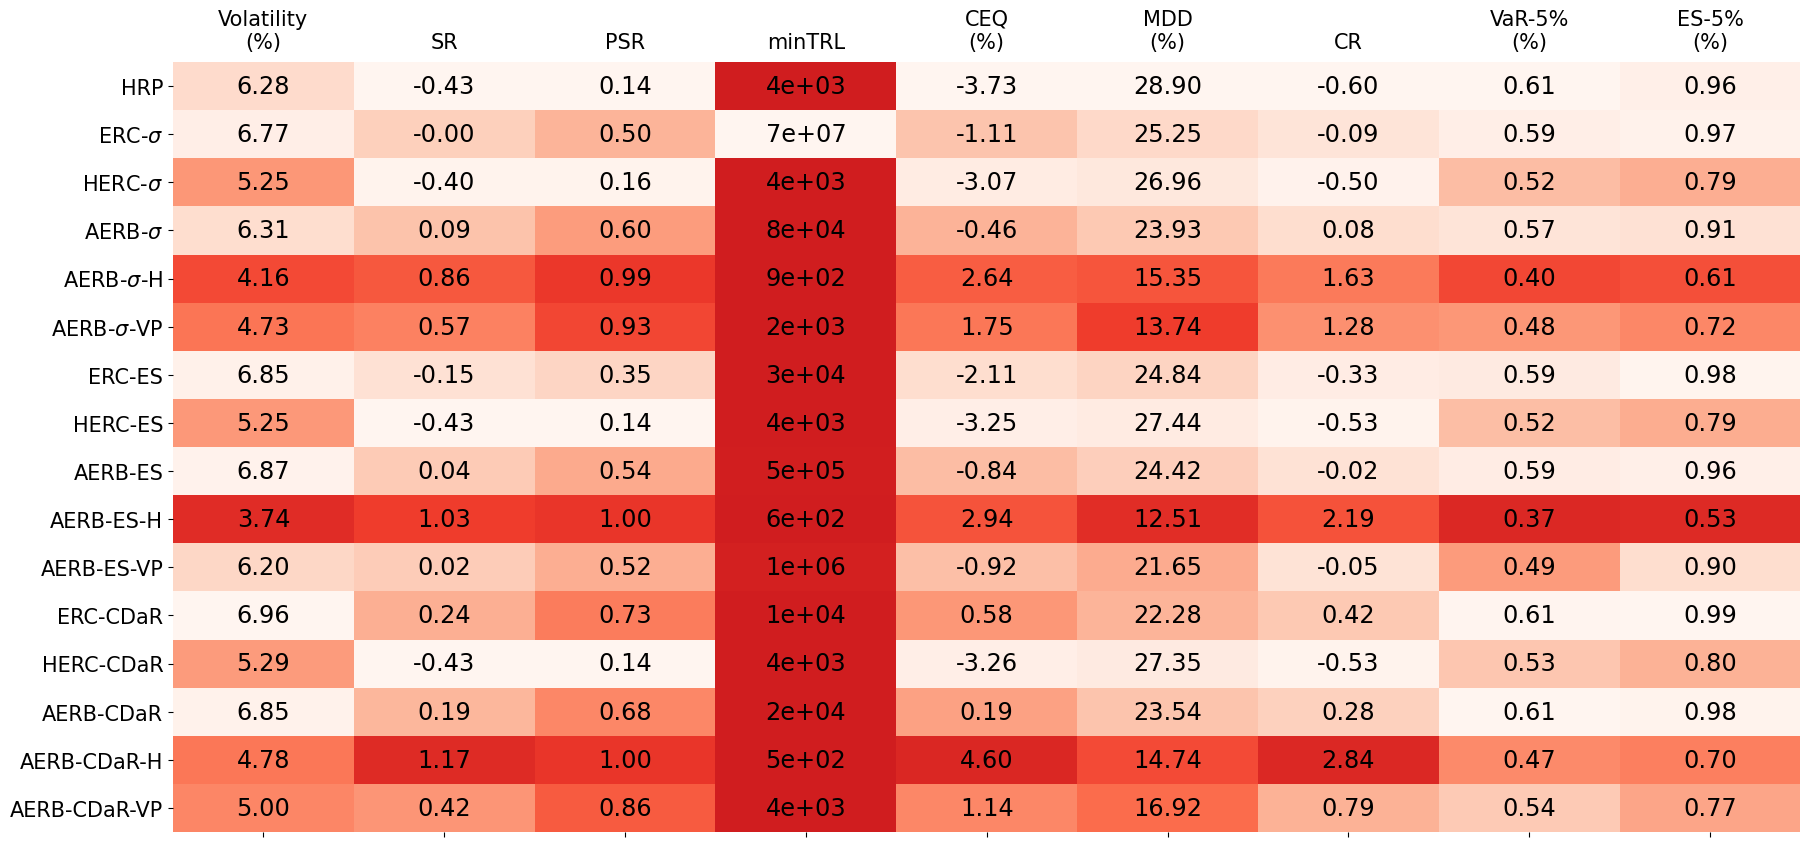

In [10]:
save = SAVE
ORDER = [
      "hrp", "erc", "herc_vol", "rb_factor", "rb_factor_hedge", "rb_factor_varspread_0.01",
      "erc_es_0.01", "herc_es_0.01", "rb_factor_es_0.01", "rb_factor_es_0.01_hedge", "rb_factor_es_0.01_varspread_0.01",
      "erc_cdar_0.01", "herc_cdar_0.01", "rb_factor_cdar_0.01", "rb_factor_cdar_0.01_hedge", "rb_factor_cdar_0.01_varspread_0.01"
]

YTICKLABELS = [
    "HRP",  "ERC-$\\sigma$", "HERC-$\\sigma$", "AERB-$\\sigma$", "AERB-$\\sigma$-H", "AERB-$\\sigma$-VP",
    "ERC-ES", "HERC-ES", "AERB-ES", "AERB-ES-H", "AERB-ES-VP",
    "ERC-CDaR", "HERC-CDaR", "AERB-CDaR", "AERB-CDaR-H", "AERB-CDaR-VP"
]
METRICS_ORDER = [
 "Volatility", "SR", "PSR", "minTRL", "CEQ", "MDD", "CR", "VaR-5%", "ES-5%"
]
pstats = stats1.loc[ORDER, METRICS_ORDER]

fig, axs = plt.subplots(1, len(METRICS_ORDER), figsize = (21,10))
i = 0
for i, c in enumerate(METRICS_ORDER):
    if c in ['Return', 'VaR-5%', 'ES-5%', 'Volatility', 'MDD', 'CEQ', 'TTO']:
        xticklabel = c + '\n(%)'
    else:
        xticklabel = c
    if c == "MT Bets_F":
        xticklabel = "$\operatorname{MT\ Bets}_F$"
    temp = pstats[[c]] 
    min_ = min(temp[c])
    if min_ < 0:
        center = 0
    else:
        center=min(temp[c]) - np.std(temp[c])
    if c in ['VaR-5%', 'ES-5%', 'Volatility', 'MDD', 'TTO', "minTRL", "SSPW", "Leverage"]:
        cmap = "Reds_r" # "Greens_r"
        vmin= min(temp[c]) - 1.5 * np.std(temp[c])
        vmax = max(temp[c])
        center=vmax
    else:
        cmap = "Reds" # "Greens"
        vmin= min(temp[c])
        vmax= max(temp[c]) + 1.5 * np.std(temp[c])
        
    sns.heatmap(np.abs(temp) if c == "SSPW" else temp,
                cmap=cmap, 
                # center=center,
                vmin=vmin,
                vmax=vmax,
                annot=True,
                fmt='.2f' if c != "minTRL" else '.1g',
                annot_kws={'color': 'black', 'size': 'xx-large', 'ha': 'center'},
                yticklabels = YTICKLABELS,
                xticklabels = [xticklabel],
                cbar=False,
                ax=axs[i])
    
    if i == 0:
        axs[i].tick_params(axis='y', labelrotation = 0, labelsize=15)
    else:
        axs[i].set_yticks([])
        
    axs[i].tick_params(axis='x', labelrotation = 0,  labelsize=15, labeltop=True, labelbottom=False)

plt.subplots_adjust(wspace=0, hspace=0)

if save:
    plt.savefig(f'{savedir}/stats_heatmap_hedge_dataset1.png', bbox_inches='tight', transparent=True)
   
    

# Dataset 2

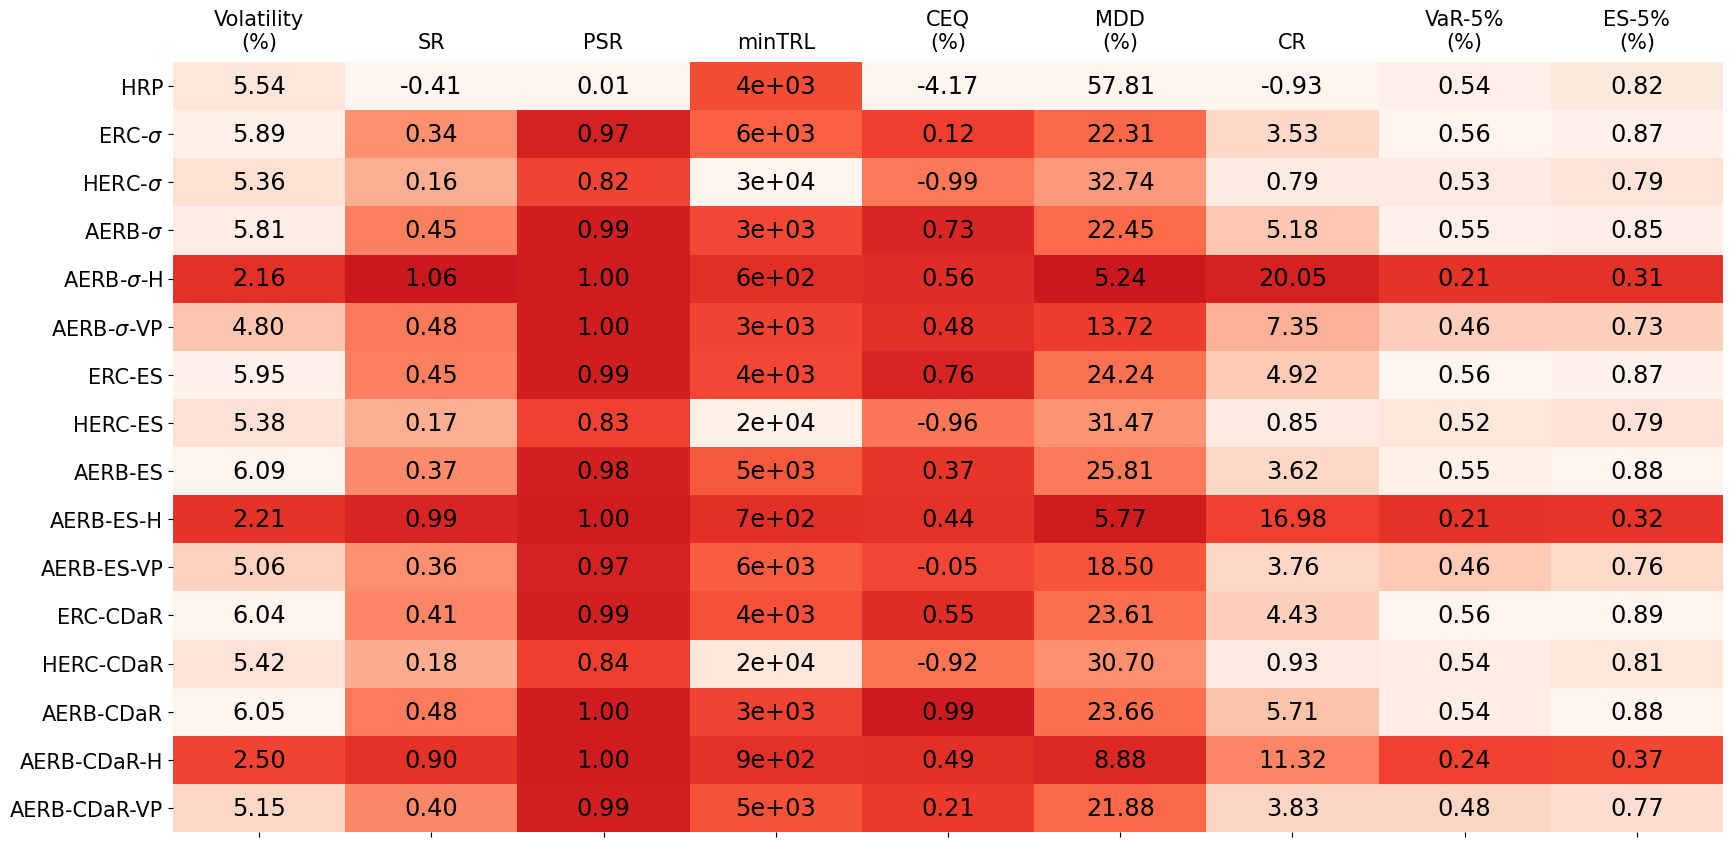

In [11]:
save = SAVE

pstats = stats2.loc[ORDER, METRICS_ORDER]
fig, axs = plt.subplots(1, len(METRICS_ORDER), figsize = (20,10))
i = 0
for i, c in enumerate(METRICS_ORDER):
    if c in ['Return', 'VaR-5%', 'ES-5%', 'Volatility', 'MDD', 'CEQ', 'TTO']:
        xticklabel = c + '\n(%)'
    else:
        xticklabel = c
    if c == "MT Bets_F":
        xticklabel = "$\operatorname{MT\ Bets}_F$"
    temp = pstats[[c]] 
    min_ = min(temp[c])
    if min_ < 0:
        center = 0
    else:
        center=min(temp[c]) - np.std(temp[c])
    if c in ['VaR-5%', 'ES-5%', 'Volatility', 'MDD', 'TTO', "minTRL", "SSPW", "Leverage"]:
        cmap = "Reds_r" # "Greens_r"
        vmin= min(temp[c]) - 1.5 * np.std(temp[c])
        vmax = max(temp[c])
        center=vmax
    else:
        cmap = "Reds" # "Greens"
        vmin= min(temp[c])
        vmax= max(temp[c]) + 1.5 * np.std(temp[c])
        
    sns.heatmap(np.abs(temp) if c == "SSPW" else temp,
                cmap=cmap, 
                # center=center,
                vmin=vmin,
                vmax=vmax,
                annot=True,
                fmt='.2f' if c != "minTRL" else '.1g',
                annot_kws={'color': 'black', 'size': 'xx-large', 'ha': 'center'},
                yticklabels = YTICKLABELS,
                xticklabels = [xticklabel],
                cbar=False,
                ax=axs[i])
    
    if i == 0:
        axs[i].tick_params(axis='y', labelrotation = 0, labelsize=15)
    else:
        axs[i].set_yticks([])
        
    axs[i].tick_params(axis='x', labelrotation = 0,  labelsize=15, labeltop=True, labelbottom=False)

plt.subplots_adjust(wspace=0, hspace=0)

if save:
    plt.savefig(f'{savedir}/stats_heatmap_hedge_dataset2.png', bbox_inches='tight', transparent=True)
   
    

# SPA Test

# First run spa_hedge.py!

## Dataset 1

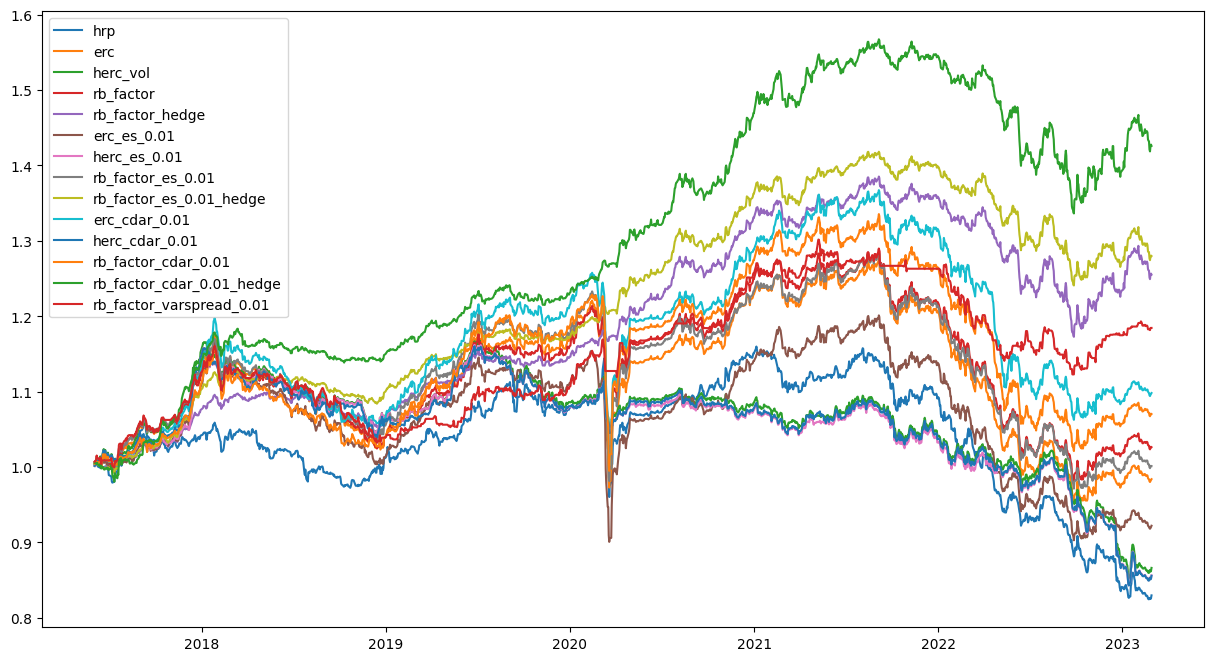

In [26]:
from arch.bootstrap import SPA
from dl_portfolio.reality_check import reality_check

plt.figure(figsize=(15,8))
plt.plot(total_return1[ORDER])
plt.plot(total_return1["rb_factor_varspread_0.01"])
plt.legend(ORDER + ["rb_factor_varspread_0.01"])
plt.show()

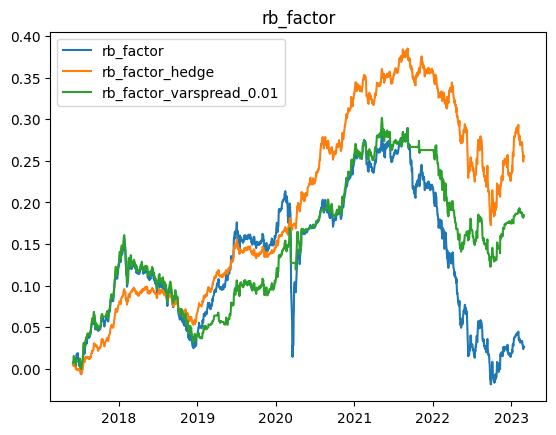

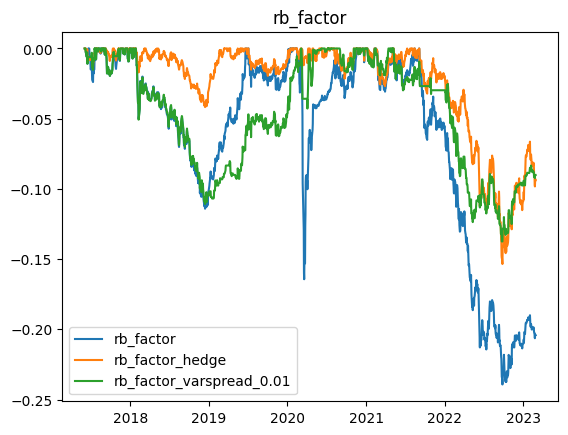

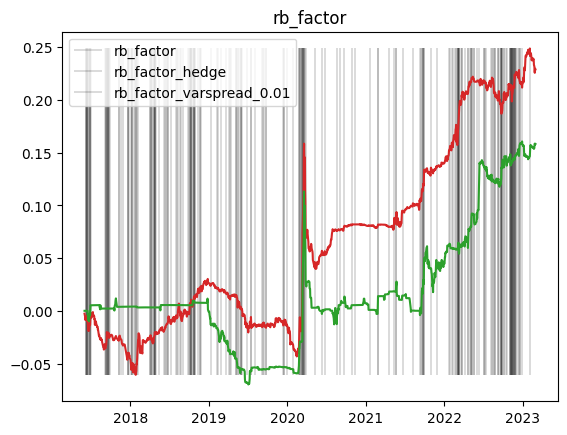

In [30]:
save=SAVE
benchmarks = [
    "rb_factor",# "rb_factor_es_0.01", "rb_factor_cdar_0.01"
]

cvs = sorted([int(cv) for cv in os.listdir("activationProba/data/dataset1") if cv.isdigit()])
tail_event1 = pd.concat(
    [
        pd.read_csv(f"activationProba/data/dataset1/{cv}/test_linear_activation.csv", index_col=0, parse_dates=True)
        for cv in cvs
    ]
)
tail_event1 = (tail_event1 <= 0).sum(1)
tail_event1 = tail_event1[tail_event1 > 0]

for bench in benchmarks:
    strat = f"{bench}_hedge"
    
    plt.plot(total_return1[bench] - 1)
    plt.plot(total_return1[strat] - 1)
    plt.plot(total_return1["rb_factor_varspread_0.01"] - 1)
    if save:
        plt.savefig(f"{savedir}/{bench}_total_returns_dataset1.png", 
                    transparent=True, bbox_inches="tight")
    else:
        plt.title(bench)
        plt.legend([bench, strat, "rb_factor_varspread_0.01"])
    plt.show()
    
    plt.plot(total_return1[bench] / total_return1[bench].cummax() - 1.0)
    plt.plot(total_return1[strat] / total_return1[strat].cummax() - 1.0)
    plt.plot(total_return1["rb_factor_varspread_0.01"] / total_return1["rb_factor_varspread_0.01"].cummax() - 1.0)
    if save:
        plt.savefig(f"{savedir}/{bench}_drawdown_dataset1.png", 
                    transparent=True, bbox_inches="tight")
    else:
        plt.title(bench)
        plt.legend([bench, strat, "rb_factor_varspread_0.01"])
    plt.show()
    
    excess_ret = total_return1[strat] - total_return1[bench]
    excess_ret_varspread = total_return1["rb_factor_varspread_0.01"] - total_return1[bench]
    for event in tail_event1.index:
        plt.vlines(event, min(excess_ret), max(excess_ret),
                   color="black", alpha=1, linewidth=0.2)
    plt.plot(excess_ret, color="tab:red")
    plt.plot(excess_ret_varspread, color="tab:green")
    if save:
        plt.savefig(f"{savedir}/{bench}_excess_returns_dataset1.png", 
                    transparent=True, bbox_inches="tight")
    else:
        plt.title(bench)
        plt.legend([bench, strat, "rb_factor_varspread_0.01"])
    plt.show()

In [45]:
save = SAVE
benchmarks = [
    "rb_factor", "rb_factor_es_0.01", "rb_factor_cdar_0.01"
]
p_values = pd.DataFrame(columns = ["returns", "sr", "mdd"], index = benchmarks)
for col_bench in benchmarks:
    col_test = col_bench + "_hedge"
    print(col_test)
    returns = perf1[[col_bench, col_test]]

    spa = SPA(-returns[col_bench], -returns[col_test], block_size=10, bootstrap="stationary", seed=0)
    spa.compute()
    p_values.loc[col_bench, "returns"] = spa.pvalues["consistent"]
    p_val = reality_check(returns, "sharpe_ratio", col_test=[col_test],
                          col_bench=col_bench, n_b=1000, seed=0)
    p_values.loc[col_bench, "sr"] = p_val
    p_val = reality_check(returns, "mdd", col_test=[col_test],
                          col_bench=col_bench, n_b=1000, seed=0)
    p_values.loc[col_bench, "mdd"] = p_val
    
n = 100
spa_ret = pd.read_pickle(f"{perf_ae_dir_1}/spa_hedge_returns_{n}.p")
for strat in spa_ret:
    col_test = f"{strat}_hedge"
    print(col_test)
    returns = pd.concat([spa_ret[strat], perf1[col_test]], axis=1)
    spa = SPA(-returns[col_test], -returns.drop(col_test, axis=1),
          block_size=10, bootstrap="stationary", seed=0)
    spa.compute()
    p_values.loc[f"random_{strat}", "returns"] = 1 - spa.pvalues["consistent"]
    p_val = reality_check(returns, "sharpe_ratio", col_test=list(range(n)),
                          col_bench=col_test, n_b=1000, seed=0)
    p_values.loc[f"random_{strat}", "sr"] = 1 - p_val
    p_val = reality_check(returns, "mdd", col_test=list(range(n)),
                          col_bench=col_test, n_b=1000, seed=0)
    p_values.loc[f"random_{strat}", "mdd"] = 1 - p_val

benchmarks = [
    "rb_factor_varspread_0.01", "rb_factor_es_0.01_varspread_0.01", "rb_factor_cdar_0.01_varspread_0.01"
]
for col_bench in benchmarks:
    col_test = col_bench[:-len("varspread_0.01")] + "hedge"
    print(col_test)
    returns = perf1[[col_bench, col_test]]

    spa = SPA(-returns[col_bench], -returns[col_test], block_size=10, bootstrap="stationary", seed=0)
    spa.compute()
    p_values.loc[col_bench, "returns"] = spa.pvalues["consistent"]
    p_val = reality_check(returns, "sharpe_ratio", col_test=[col_test],
                          col_bench=col_bench, n_b=1000, seed=0)
    p_values.loc[col_bench, "sr"] = p_val
    p_val = reality_check(returns, "mdd", col_test=[col_test],
                          col_bench=col_bench, n_b=1000, seed=0)
    p_values.loc[col_bench, "mdd"] = p_val

p_values.columns = ["$\\operatorname{E}(R_t)$", "SR", "MDD"]
p_values = p_values.astype(float)
p_values

rb_factor_hedge
rb_factor_es_0.01_hedge
rb_factor_cdar_0.01_hedge
rb_factor_hedge
rb_factor_es_0.01_hedge
rb_factor_cdar_0.01_hedge
rb_factor_hedge
rb_factor_es_0.01_hedge
rb_factor_cdar_0.01_hedge


,$\operatorname{E}(R_t)$,SR,MDD
rb_factor,0.101,0.000,0.017
rb_factor_es_0.01,0.105,0.000,0.000
rb_factor_cdar_0.01,0.071,0.000,0.001
random_rb_factor,0.019,0.000,0.004
random_rb_factor_es_0.01,0.024,0.002,0.120
random_rb_factor_cdar_0.01,0.046,0.005,0.012
rb_factor_varspread_0.01,0.267,0.098,0.883
rb_factor_es_0.01_varspread_0.01,0.105,0.016,0.230
rb_factor_cdar_0.01_varspread_0.01,0.030,0.002,0.073


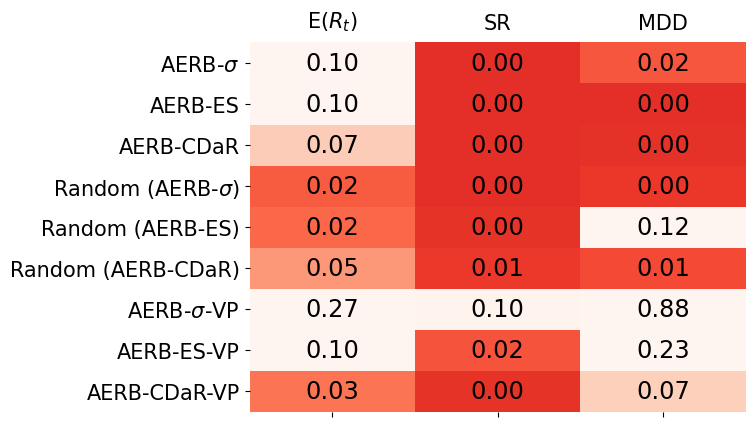

In [46]:
save=SAVE
YTICKLABELS = [
    "AERB-$\\sigma$", "AERB-ES", "AERB-CDaR", 
    "Random (AERB-$\\sigma$)", "Random (AERB-ES)", "Random (AERB-CDaR)",
    "AERB-$\\sigma$-VP", "AERB-ES-VP", "AERB-CDaR-VP", 
]
fig, axs = plt.subplots(1, p_values.shape[-1]) # , figsize = (21,10)
i = 0
for i, c in enumerate(p_values.columns):
    temp = p_values[[c]] 
    vmax = 0.1
    vmin = -0.05
    sns.heatmap(temp,
                cmap="Reds_r", 
                vmin=vmin,
                vmax=vmax,
                annot=True,
                fmt='.2f',
                annot_kws={'color': 'black', 'size': 'xx-large', 'ha': 'center'},
                yticklabels = YTICKLABELS,
                xticklabels = [c],
                cbar=False,
                ax=axs[i])
    
    if i == 0:
        axs[i].tick_params(axis='y', labelrotation = 0, labelsize=15)
    else:
        axs[i].set_yticks([])
        
    axs[i].tick_params(axis='x', labelrotation = 0,  labelsize=15, labeltop=True, labelbottom=False)
plt.subplots_adjust(wspace=0, hspace=0)
if save:
    plt.savefig(f'{savedir}/spa_p_values_hedge_dataset1.png', bbox_inches='tight', transparent=True)

# Dataset 2

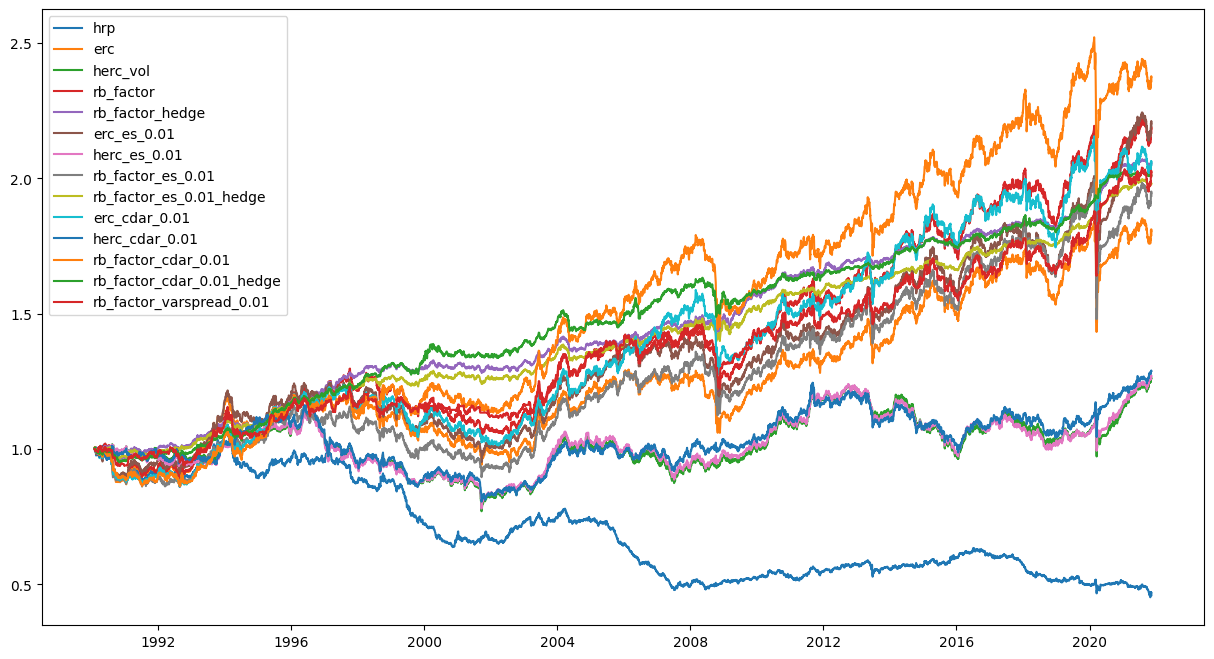

In [50]:
plt.figure(figsize=(15,8))
plt.plot(total_return2[ORDER])
plt.plot(total_return2["rb_factor_varspread_0.01"])
plt.legend(ORDER + ["rb_factor_varspread_0.01"])
plt.show()

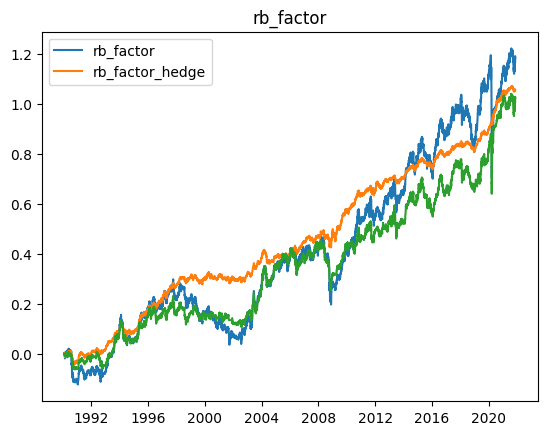

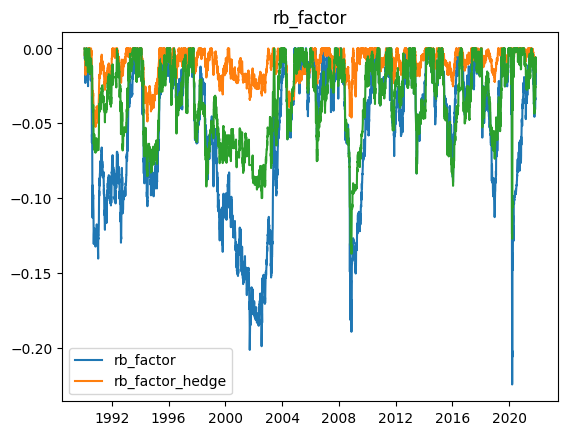

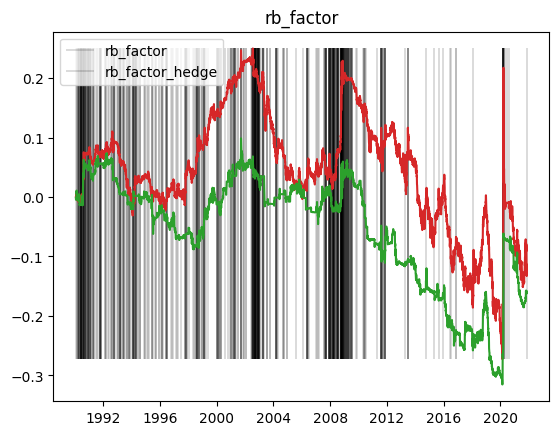

In [49]:
save=False
benchmarks = [
    "rb_factor",# "rb_factor_es_0.01", "rb_factor_cdar_0.01"
]

cvs = sorted([int(cv) for cv in os.listdir("activationProba/data/dataset2") if cv.isdigit()])
tail_event2 = pd.concat(
    [
        pd.read_csv(f"activationProba/data/dataset2/{cv}/test_linear_activation.csv", index_col=0, parse_dates=True)
        for cv in cvs
    ]
)
tail_event2 = (tail_event2 <= 0).sum(1)
tail_event2 = tail_event2[tail_event2 > 0]


for bench in benchmarks:
    strat = f"{bench}_hedge"
    
    plt.plot(total_return2[bench] - 1)
    plt.plot(total_return2[strat] - 1)
    plt.plot(total_return2["rb_factor_varspread_0.01"] - 1)
    if save:
        plt.savefig(f"{savedir}/{bench}_total_returns_dataset2.png", 
                    transparent=True, bbox_inches="tight")
    else:
        plt.title(bench)
        plt.legend([bench, strat])
    plt.show()
    
    plt.plot(total_return2[bench] / total_return2[bench].cummax() - 1.0)
    plt.plot(total_return2[strat] / total_return2[strat].cummax() - 1.0)
    plt.plot(total_return2["rb_factor_varspread_0.01"] / total_return2["rb_factor_varspread_0.01"].cummax() - 1.0)
    if save:
        plt.savefig(f"{savedir}/{bench}_drawdown_dataset2.png", 
                    transparent=True, bbox_inches="tight")
    else:
        plt.title(bench)
        plt.legend([bench, strat])
    plt.show()
    
    excess_ret = total_return2[strat] - total_return2[bench]
    for event in tail_event2.index:
        plt.vlines(event, min(excess_ret), max(excess_ret),
                   color="black", alpha=1, linewidth=0.2)        
    plt.plot(excess_ret, color="tab:red")
    excess_ret = total_return2["rb_factor_varspread_0.01"] - total_return2[bench]        
    plt.plot(excess_ret, color="tab:green")
    if save:
        plt.savefig(f"{savedir}/{bench}_excess_returns_dataset2.png", 
                    transparent=True, bbox_inches="tight")
    else:
        plt.title(bench)
        plt.legend([bench, strat])
    plt.show()

In [47]:
save = SAVE
benchmarks = [
    "rb_factor", "rb_factor_es_0.01", "rb_factor_cdar_0.01"
]
p_values = pd.DataFrame(columns = ["returns", "sr", "mdd"], index = benchmarks)
for col_bench in benchmarks:
    col_test = col_bench + "_hedge"
    print(col_test)
    returns = perf2[[col_bench, col_test]]

    spa = SPA(-returns[col_bench], -returns[col_test], block_size=10, bootstrap="stationary", seed=0)
    spa.compute()
    p_values.loc[col_bench, "returns"] = spa.pvalues["consistent"]
    p_val = reality_check(returns, "sharpe_ratio", col_test=[col_test],
                          col_bench=col_bench, n_b=1000, seed=0)
    p_values.loc[col_bench, "sr"] = p_val
    p_val = reality_check(returns, "mdd", col_test=[col_test],
                          col_bench=col_bench, n_b=1000, seed=0)
    p_values.loc[col_bench, "mdd"] = p_val
    
n = 100
spa_ret = pd.read_pickle(f"{perf_ae_dir_2}/spa_hedge_returns_{n}.p")
for strat in spa_ret:
    col_test = f"{strat}_hedge"
    print(col_test)
    returns = pd.concat([spa_ret[strat], perf2[col_test]], axis=1)
    spa = SPA(-returns[col_test], -returns.drop(col_test, axis=1),
          block_size=10, bootstrap="stationary", seed=0)
    spa.compute()
    p_values.loc[f"random_{strat}", "returns"] = 1 - spa.pvalues["consistent"]
    p_val = reality_check(returns, "sharpe_ratio", col_test=list(range(n)),
                          col_bench=col_test, n_b=1000, seed=0)
    p_values.loc[f"random_{strat}", "sr"] = 1 - p_val
    p_val = reality_check(returns, "mdd", col_test=list(range(n)),
                          col_bench=col_test, n_b=1000, seed=0)
    p_values.loc[f"random_{strat}", "mdd"] = 1 - p_val

benchmarks = [
    "rb_factor_varspread_0.01", "rb_factor_es_0.01_varspread_0.01", "rb_factor_cdar_0.01_varspread_0.01"
]
for col_bench in benchmarks:
    col_test = col_bench[:-len("varspread_0.01")] + "hedge"
    print(col_test)
    returns = perf2[[col_bench, col_test]]

    spa = SPA(-returns[col_bench], -returns[col_test], block_size=10, bootstrap="stationary", seed=0)
    spa.compute()
    p_values.loc[col_bench, "returns"] = spa.pvalues["consistent"]
    p_val = reality_check(returns, "sharpe_ratio", col_test=[col_test],
                          col_bench=col_bench, n_b=1000, seed=0)
    p_values.loc[col_bench, "sr"] = p_val
    p_val = reality_check(returns, "mdd", col_test=[col_test],
                          col_bench=col_bench, n_b=1000, seed=0)
    p_values.loc[col_bench, "mdd"] = p_val

p_values.columns = ["$\\operatorname{E}(R_t)$", "SR", "MDD"]
p_values = p_values.astype(float)
p_values

rb_factor_hedge
rb_factor_es_0.01_hedge
rb_factor_cdar_0.01_hedge
rb_factor_hedge
rb_factor_es_0.01_hedge
rb_factor_cdar_0.01_hedge
rb_factor_hedge
rb_factor_es_0.01_hedge
rb_factor_cdar_0.01_hedge


,$\operatorname{E}(R_t)$,SR,MDD
rb_factor,0.631,0.000,0.022
rb_factor_es_0.01,0.540,0.000,0.003
rb_factor_cdar_0.01,0.771,0.005,0.010
random_rb_factor,0.033,0.004,0.001
random_rb_factor_es_0.01,0.044,0.012,0.001
random_rb_factor_cdar_0.01,0.164,0.015,0.001
rb_factor_varspread_0.01,0.533,0.000,0.016
rb_factor_es_0.01_varspread_0.01,0.315,0.000,0.077
rb_factor_cdar_0.01_varspread_0.01,0.443,0.013,0.023


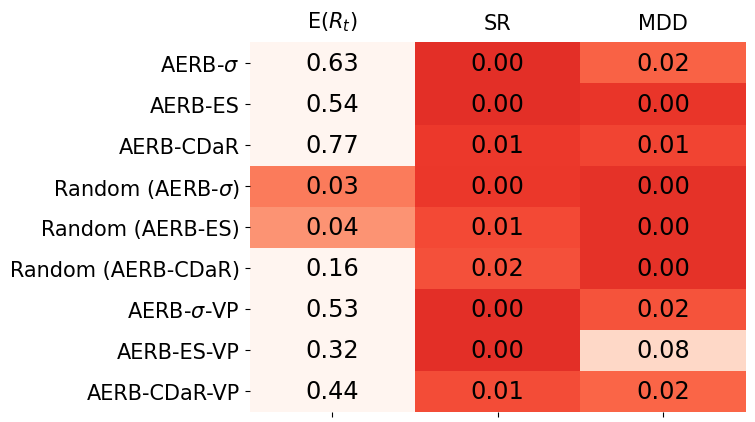

In [48]:
save=SAVE
YTICKLABELS = [
    "AERB-$\\sigma$", "AERB-ES", "AERB-CDaR", 
    "Random (AERB-$\\sigma$)", "Random (AERB-ES)", "Random (AERB-CDaR)",
    "AERB-$\\sigma$-VP", "AERB-ES-VP", "AERB-CDaR-VP", 
]
fig, axs = plt.subplots(1, p_values.shape[-1]) # , figsize = (21,10)
i = 0
for i, c in enumerate(p_values.columns):
    temp = p_values[[c]] 
    vmax = 0.1
    vmin = -0.05
    sns.heatmap(temp,
                cmap="Reds_r", 
                vmin=vmin,
                vmax=vmax,
                annot=True,
                fmt='.2f',
                annot_kws={'color': 'black', 'size': 'xx-large', 'ha': 'center'},
                yticklabels = YTICKLABELS,
                xticklabels = [c],
                cbar=False,
                ax=axs[i])
    
    if i == 0:
        axs[i].tick_params(axis='y', labelrotation = 0, labelsize=15)
    else:
        axs[i].set_yticks([])
        
    axs[i].tick_params(axis='x', labelrotation = 0,  labelsize=15, labeltop=True, labelbottom=False)
plt.subplots_adjust(wspace=0, hspace=0)
if save:
    plt.savefig(f'{savedir}/spa_p_values_hedge_dataset2.png', bbox_inches='tight', transparent=True)